In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [4]:
from sklearn.model_selection import train_test_split

# device set

In [141]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Make Data

In [227]:
INPUT_FEATURES = 2  
CENTERS = 5

In [228]:
x,y = make_blobs(n_samples=1000, n_features=INPUT_FEATURES, centers = CENTERS, cluster_std = 1.5, random_state=42)

In [229]:
x.shape, y.shape

((1000, 2), (1000,))

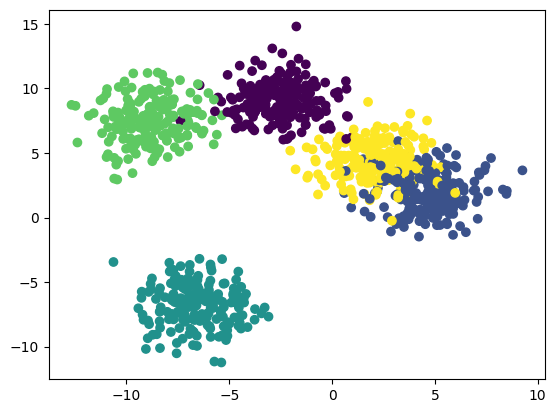

In [230]:
plt.scatter(x = x[:,0], y = x[:,1], c = y)

In [231]:
xtrai, xtes, ytrai, ytes = train_test_split(x,y, test_size = .1, random_state=42, stratify=y)

In [232]:
print('xtrain: ', xtrai.shape)
print('ytrain: ', ytrai.shape)
print('xtest: ', xtes.shape)
print('ytest: ', ytes.shape)

xtrain:  (900, 2)
ytrain:  (900,)
xtest:  (100, 2)
ytest:  (100,)


In [233]:
xtrain = torch.from_numpy(xtrai).type(torch.float).to(device)
ytrain = torch.from_numpy(ytrai).type(torch.LongTensor).to(device)
xtest = torch.from_numpy(xtes).type(torch.float).to(device)
ytest   = torch.from_numpy(ytes).type(torch.LongTensor).to(device)

In [234]:
xtrain.requires_grad_(True)
xtest.requires_grad_(True)


tensor([[  3.0840,   1.6877],
        [-10.4465,   2.9415],
        [ -3.9815,   9.7074],
        [  0.3201,   9.2762],
        [  2.5011,   6.1721],
        [ -5.2174,  -8.4400],
        [  3.0677,   3.6607],
        [ -7.7124,  -4.0584],
        [ -8.9708,  11.1931],
        [ -5.9215,  -8.5946],
        [ -8.1282,  -6.1730],
        [ -2.1417,   8.2539],
        [  4.6675,   2.4945],
        [ -9.2145,  -7.5223],
        [ -4.1106,   8.8007],
        [ -2.4219,   7.2998],
        [ -9.1780,   7.8746],
        [  2.5069,   3.7829],
        [ -9.0052,   5.9677],
        [  1.1992,   4.3007],
        [  1.0601,   4.8093],
        [  6.3638,   0.9184],
        [  6.9246,   2.7815],
        [  2.5203,   4.4472],
        [ -5.2796,  -5.1262],
        [  0.8630,   4.7720],
        [ -4.6323,   8.3833],
        [ -3.6047,   9.3390],
        [  2.3049,   2.8822],
        [ -2.6810,  10.8710],
        [  4.8962,   1.6972],
        [  5.6079,   4.0261],
        [ -7.2657,  -9.3830],
        [ 

# Model

In [235]:
class MultiClass(nn.Module):
    def __init__(self, input_features, output_features, units=8):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features = units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features = units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features = output_features)
        )

    def forward(self, x):
        return self.layers(x)

In [257]:
model = MultiClass(input_features=INPUT_FEATURES, output_features=CENTERS, units = 32).to(device)

In [258]:
# model.state_dict()

In [259]:
xtest.shape

torch.Size([100, 2])

In [260]:
ppred = model(xtest)

In [261]:
ppred.shape

torch.Size([100, 5])

# optimizers and Loss


In [262]:
# optimizers and Loss
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr = .001)

In [263]:
# Accuracy
def accuracy(ytrue, ypred):
    ypred = torch.argmax(ypred, axis = -1)
    correct = torch.eq(ytrue, ypred).sum().item()
    return (correct/len(ypred))*100

# Training Loop

In [264]:
epoch = 10000

losses = []
test_losses = []
acc = []
test_acc = []
epochs_list = []


for i in range(epoch):

    model.train()

    ypred_logits = model(xtrain)
    ypred = torch.softmax(ypred_logits, dim = -1) #.argmax(dim=-1)
    # print('ypred: ', ypred.dtype, ypred.shape)
    # print('ytrain: ', ytrain.dtype, ytrain.shape)


    # loss
    loss = loss_fn(ypred,ytrain)
    train_accuracy = accuracy(ytrain, ypred)

    # # optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 ==0 or i==(epoch-1):
        
        model.eval()
        with torch.inference_mode():
            test_ypred_logits = model(xtest)

        test_ypred = torch.softmax(test_ypred_logits, dim=-1) #.argmax(dim=-1)
        # test_ypred = torch.argmax(test_ypred_probs, axis = -1).type(torch.float)
        
        test_loss = loss_fn(test_ypred, ytest)
        
        # accuracy
        test_accuracy = accuracy(ytest, test_ypred)
        train_accuracy = accuracy(ytrain, ypred)

        # appending values
        test_losses.append(test_loss)
        losses.append(loss)
        epochs_list.append(i)

        acc.append(train_accuracy)
        test_acc.append(test_accuracy)

        print(f'epoch : {i:5}  | loss : {loss:.5f}  accuracy : {train_accuracy:.5f} | test_loss : {test_loss:.5f}  test_acc : {test_accuracy:.5f}')

epoch :     0  | loss : 1.62643  accuracy : 22.66667 | test_loss : 1.62273  test_acc : 26.00000
epoch :    50  | loss : 1.61541  accuracy : 23.11111 | test_loss : 1.61195  test_acc : 26.00000
epoch :   100  | loss : 1.60287  accuracy : 24.33333 | test_loss : 1.59971  test_acc : 29.00000
epoch :   150  | loss : 1.58848  accuracy : 41.33333 | test_loss : 1.58566  test_acc : 43.00000
epoch :   200  | loss : 1.57204  accuracy : 40.22222 | test_loss : 1.56966  test_acc : 40.00000
epoch :   250  | loss : 1.55408  accuracy : 41.00000 | test_loss : 1.55228  test_acc : 42.00000
epoch :   300  | loss : 1.53516  accuracy : 54.33333 | test_loss : 1.53402  test_acc : 53.00000
epoch :   350  | loss : 1.51579  accuracy : 57.77778 | test_loss : 1.51538  test_acc : 59.00000
epoch :   400  | loss : 1.49636  accuracy : 58.88889 | test_loss : 1.49670  test_acc : 59.00000
epoch :   450  | loss : 1.47726  accuracy : 58.88889 | test_loss : 1.47831  test_acc : 59.00000
epoch :   500  | loss : 1.45893  accurac

In [265]:
model.eval()
with torch.inference_mode():
    ypred = model(xtest)
    ypred = torch.softmax(ypred, dim = -1).argmax(dim = -1)

ypred.shape, ypred.dtype

(torch.Size([100]), torch.int64)

In [266]:
ypred = ypred.cpu().numpy()

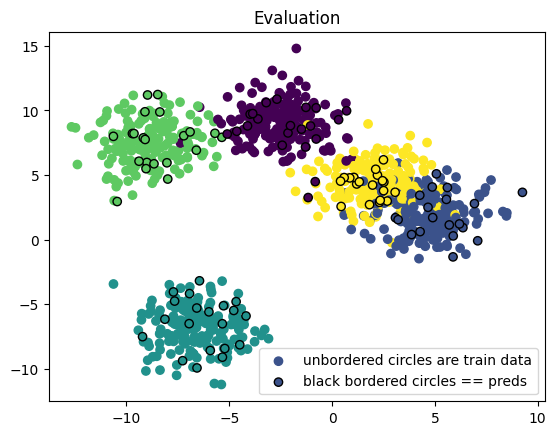

In [267]:

plt.scatter(x = xtrai[:,0], y = xtrai[:,1], c = ytrai, label='unbordered circles are train data')
plt.scatter(x = xtes[:,0], y = xtes[:,1], c = ypred, edgecolor='black', label = 'black bordered circles == preds')
plt.title('Evaluation')
plt.legend()

# here black bordered circles are predicted values , and the perfectly align ( with 90% accuracy) with same clusters.(color of black bordered circle matchs the color of the group of circles )

Model can be made better with different hyperparameter and with different bigger and complex architecture to achive better results. 

In [268]:
losses = [i.cpu().item() for i in losses]
test_losses = [i.cpu().item() for i in test_losses]

Text(0.5, 1.0, 'LOSS')

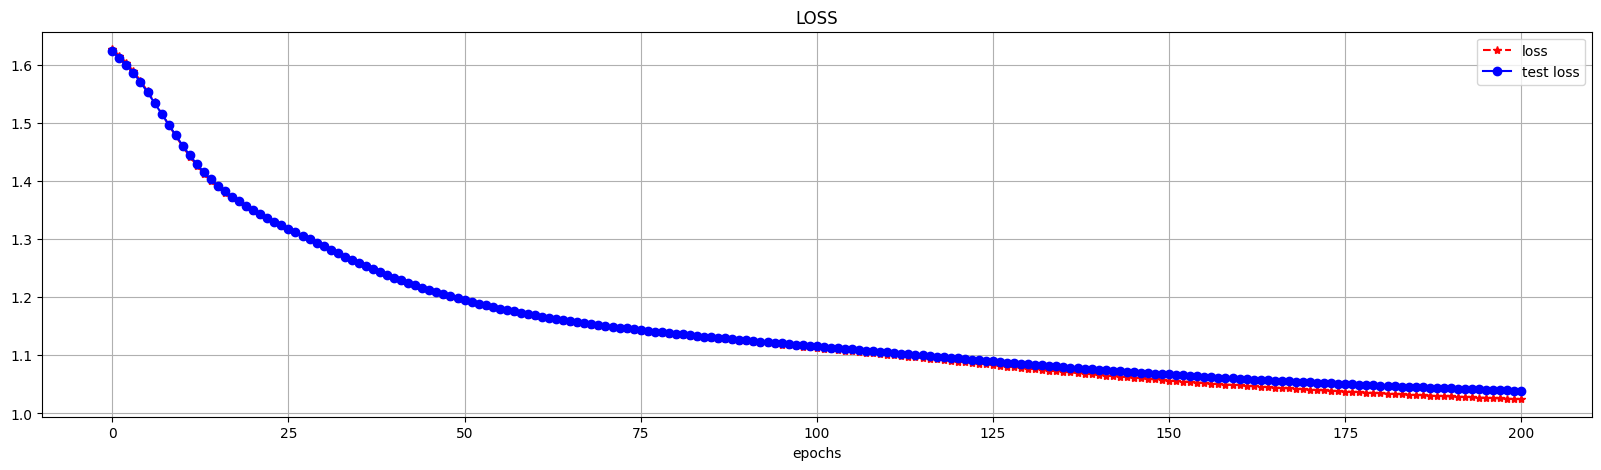

In [269]:
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(losses, label='loss', marker = '*', linestyle = '--', color = 'red')
plt.plot(test_losses, label='test loss', marker='o', color='blue')
plt.xlabel('epochs')
plt.legend()
plt.title('LOSS')

Text(0.5, 1.0, 'Accuracy')

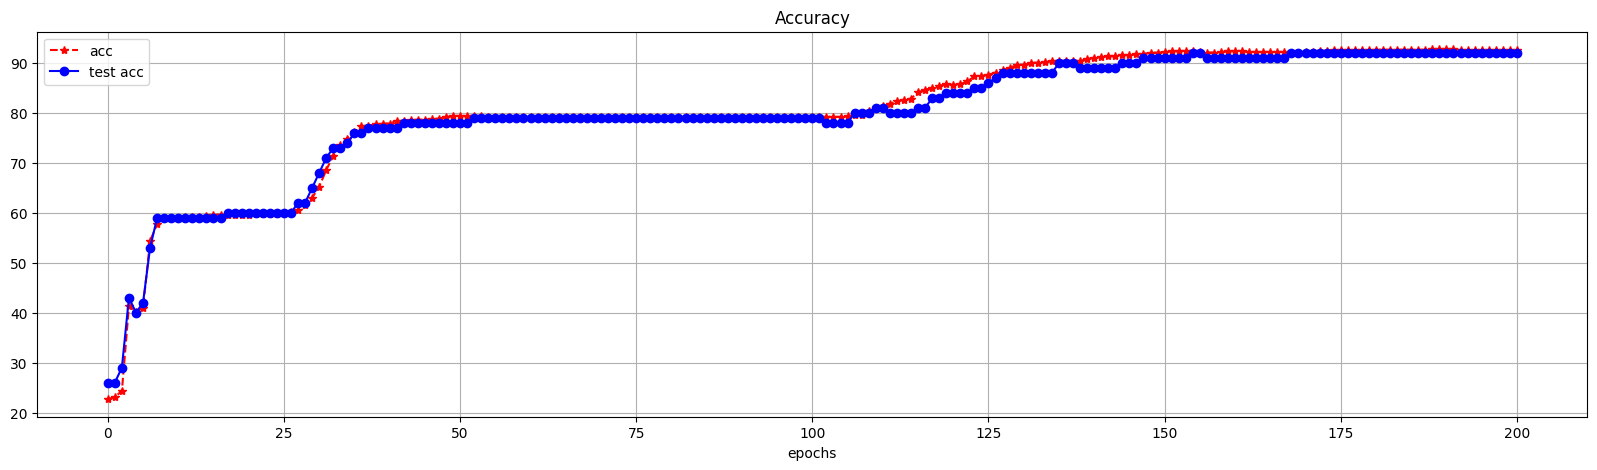

In [270]:
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(acc, label='acc', marker = '*', linestyle = '--', color = 'red')
plt.plot(test_acc, label='test acc', marker='o', color='blue')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy')